In [1]:
from module import decomposition
from module import dickey_fuller
from module import arima_endog
from module import arima_exog
from module import rmse_cv
from module import lasso_reg


import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import hstack
import warnings
import os
from fredapi import Fred
warnings.filterwarnings('ignore')

import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
from pmdarima import model_selection

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

%matplotlib inline
%load_ext autoreload
%autoreload

Using TensorFlow backend.


# NEED TO CHANGE EXOGENOUS VARIABLES PER LASSO REGRESSION

### Set Datetime

In [2]:
start = datetime(2000,2,1)
end = datetime(2020,1,31)

## Gather Endogenous Data 

In [3]:
FR = web.DataReader('FR', 'av-daily', start = start, end = end, api_key = 'Y8YQFOIVHPA381U4')
FR = FR.copy()
FR.index = pd.to_datetime(FR.index)
FR = FR.resample('MS').mean()
FR['mid'] = (FR['high']+FR['low'])/2
FR.drop(labels = ['high', 'low', 'open', 'close', 'volume'], axis = 1, inplace = True)

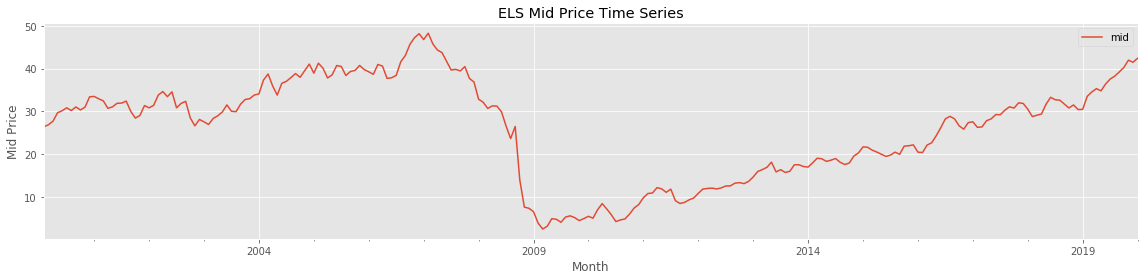

In [4]:
plt.style.use('ggplot')
FR.plot(figsize = (16,4))
plt.xlabel('Month')
plt.ylabel('Mid Price')
plt.title('ELS Mid Price Time Series')
plt.tight_layout()
plt.show();

## Perform Decomposition of Time Series

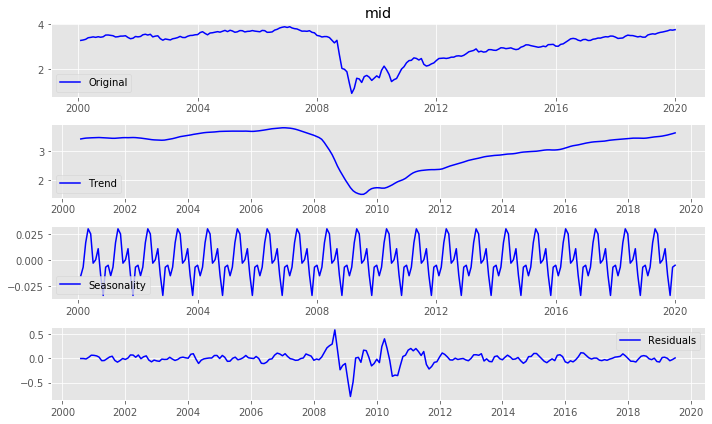

In [5]:
decomposition(FR)

In [6]:
FR_diff = FR.diff(periods = 1).dropna()

In [7]:
dickey_fuller(FR_diff)

The series passes the Dickey Fuller Test for Stationarity. P-Value = 0.0061575315289557455


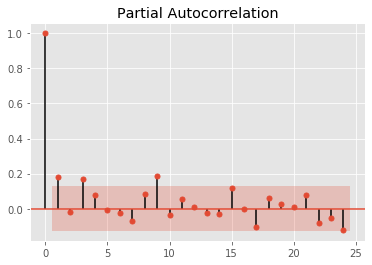

In [8]:
plot_pacf(FR_diff);

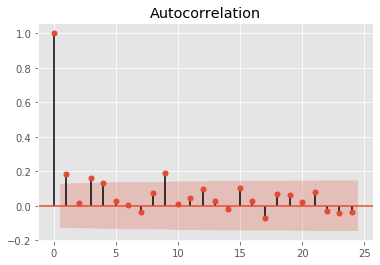

In [9]:
plot_acf(FR_diff);

In [13]:
parameters = (3,1,3)
seasonal_parameters = (3,1,3,12)

## Train Test Split

In [14]:
FR_train = FR[:'2015']
FR_test = FR['2016':]

## SARIMAX Model (No Exogenous Variables)

Summary:                                  Statespace Model Results                                 
Dep. Variable:                                mid   No. Observations:                  191
Model:             SARIMAX(3, 1, 3)x(3, 1, 3, 12)   Log Likelihood                -275.003
Date:                            Fri, 07 Feb 2020   AIC                            578.007
Time:                                    18:39:03   BIC                            618.988
Sample:                                02-01-2000   HQIC                           594.661
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0003      0.001      0.277      0.782      -0.002       0.002
ar.L1          0.8990     

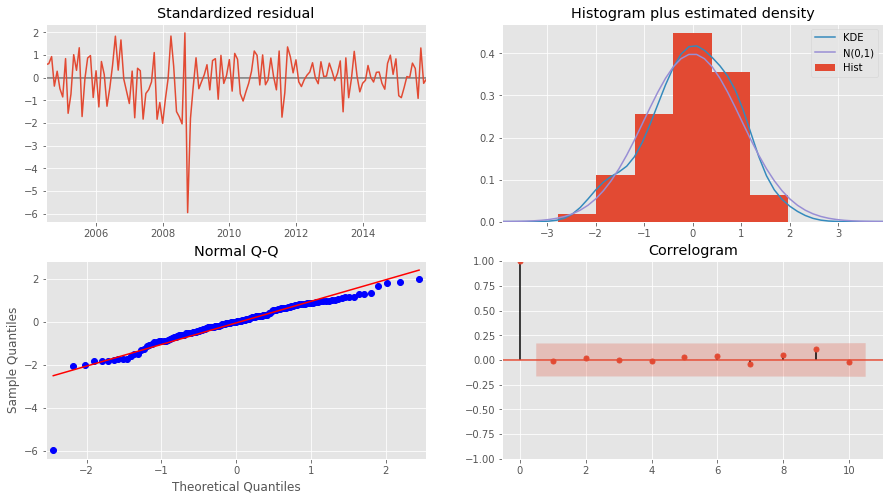

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Predictions vs. Observed: 
 


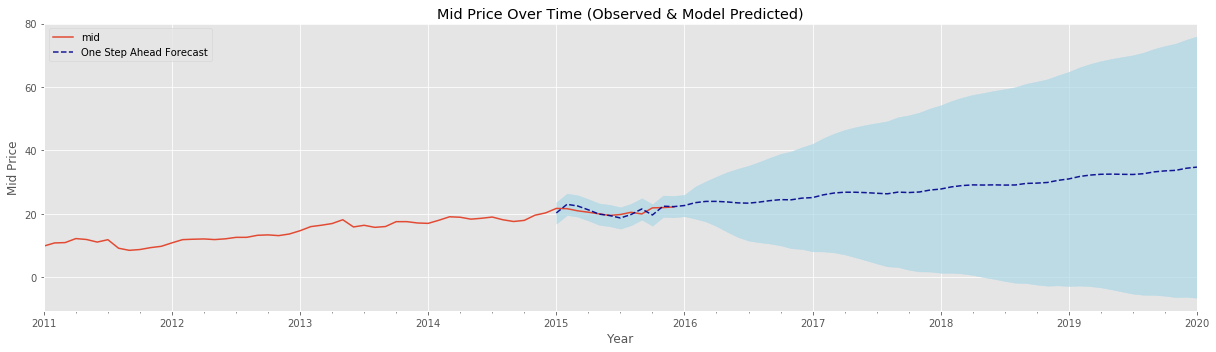

--------------------------------------------------------------------------------------------------------------------------------------------------------------
 
Future Forecast: 
 


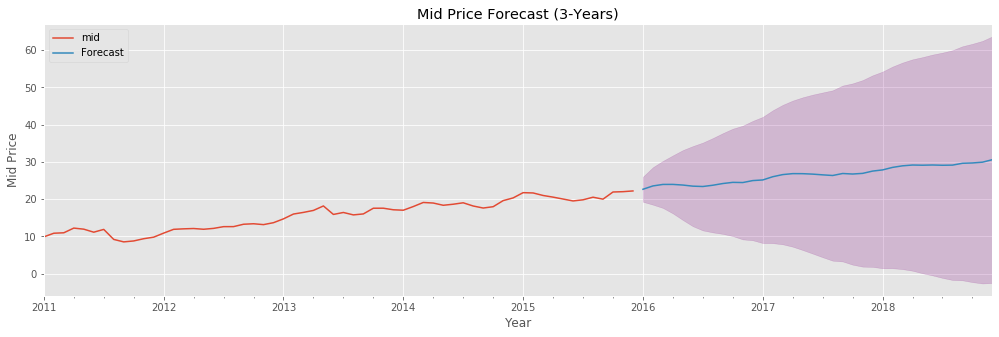

In [15]:
arima_endog(FR_train, parameters, seasonal_parameters)

## Gather Exogenous Variables

In [18]:
FR_rates = pd.read_csv('data/FR_rates.csv', index_col = 'date')

### Train Test Split Exogenous Variables

### Perform Lasso Regression

The R-score of the Lasso Regression is: 0.9878729586083098

usd1mtd156n       -3.197451
mortgage30us      -1.248196
mortgage15us      -2.976175
dcpf3m             4.080561
cpn3m             -0.192908
dcpf1m            -0.888217
aaa               -0.698094
baa               -1.452166
dff                4.316908
flexsc            -0.429874
t10y2y            -0.000000
t10y3m             2.986316
tedrate           -2.349787
t10yff             0.504435
t5yff             -1.699348
tb6smffm           5.316759
usd3mtd156n        1.378603
usd12md156n        0.968437
eur1wkd156n        1.049401
mprime            -0.948908
tb3ms              0.000000
dtb6               0.596743
dgs10              0.549402
dgs3mo            -1.052516
dexuseu            5.408603
dexchus            3.530692
dexusuk           13.180269
dexsius           21.710629
nasdaqcom         -0.005058
willreitind        0.003777
willlrgcap         0.000445
willsmlcap         0.000195
vxdcls            -0.221862
stlfsi          

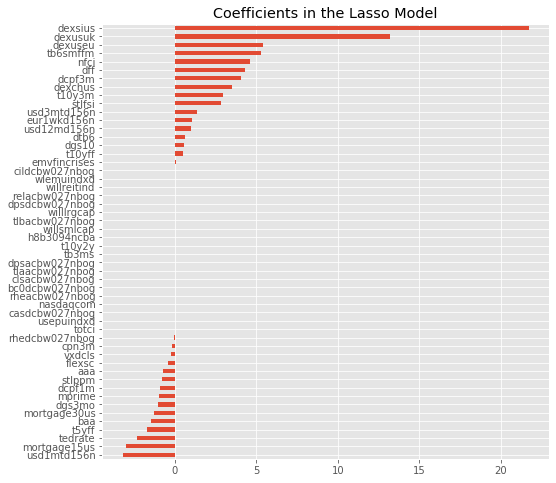

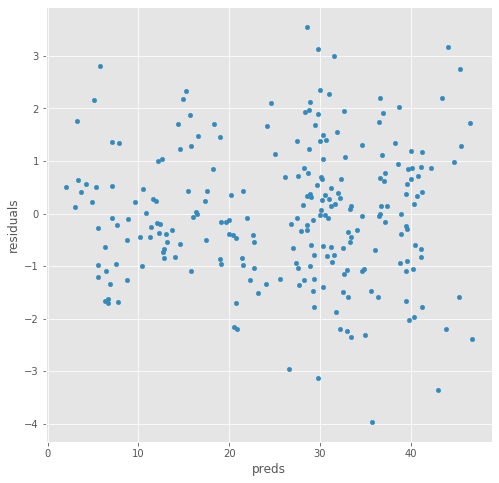

In [17]:
lasso_reg(FR_rates)

### Select significant exogenous features from Lasso Regression

In [19]:
FR_rates_train = FR_rates[:'2016']
FR_rates_test = FR_rates['2016':]

In [20]:
exog_train = FR_rates_train[['nasdaqcom', 'willreitind', 'willlrgcap', 'willsmlcap', 'vxdcls', 'h8b3094ncba', 'bc0dcbw027nbog', 'casdcbw027nbog', 'cildcbw027nbog',
                              'dpsdcbw027nbog', 'clsacbw027nbog', 'dpsacbw027nbog', 'relacbw027nbog', 'rheacbw027nbog', 'tlaacbw027nbog', 'tlbacbw027nbog', 'totci',
                              'usepuindxd', 'wlemuindxd']]

In [21]:
exog_test = FR_rates_test[['nasdaqcom', 'willreitind', 'willlrgcap', 'willsmlcap', 'vxdcls', 'h8b3094ncba', 'bc0dcbw027nbog', 'casdcbw027nbog', 'cildcbw027nbog',
                              'dpsdcbw027nbog', 'clsacbw027nbog', 'dpsacbw027nbog', 'relacbw027nbog', 'rheacbw027nbog', 'tlaacbw027nbog', 'tlbacbw027nbog', 'totci',
                              'usepuindxd', 'wlemuindxd']]

In [21]:
exog_train.shape, exog_test.shape

((191, 19), (49, 19))

In [23]:
arima_model = sm.tsa.statespace.SARIMAX(FR_train,
                                        exog = exog_train,
                                        order = parameters,
                                        seasonal_order = seasonal_parameters,
                                        enforce_stationarity = False,
                                        enforce_invertability = False,
                                        trend = 't')
results = arima_model.fit()
print(f'Summary: {results.summary()}')
print()
print('Diagnostics: ')
results.plot_diagnostics(figsize = (15,8))
plt.show()

NameError: name 'PLD_train' is not defined

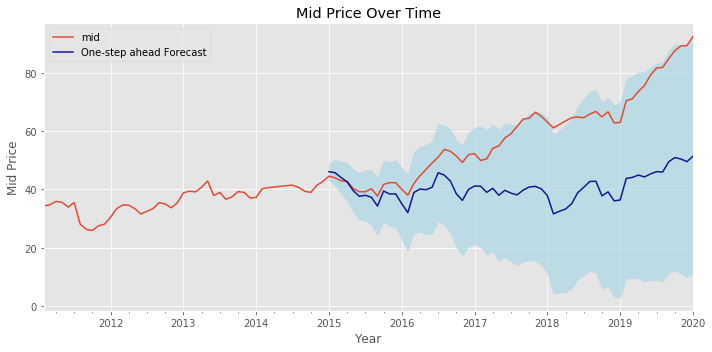

In [23]:
predictions = results.get_prediction(start = pd.to_datetime('2015-01-01'), end = pd.to_datetime('2020-01-01'), dynamic=True, exog = exog_test)
pred_conf = predictions.conf_int()
    
#Plot observed values
ax = FR['2011-02-01':].plot(label='observed', figsize = (10,5))

#Plot predicted values
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, color = 'darkblue')

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='lightblue', alpha=.7)

#Set axes labels
ax.set_xlabel('Year')
ax.set_ylabel('Mid Price')
plt.legend(loc = 'best')
plt.title(f'Mid Price Over Time')
plt.tight_layout()
plt.show()
    